<a href="https://colab.research.google.com/github/yaoshiang/exact-binomial-test-for-marketers/blob/main/EBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Error Bars for Marketing Funnels

This is a companion notebook to the article at:

https://yaoshiang.com/ebt.html


# Get Dataset

Create a kaggle account at https://kaggle.com and naviate to this page. Download the dataset, then upload to the files section of this notebook.

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [ ]:
# Verify that the dataset file exists.
import csv

try:
  with open("./creditcard.csv") as f:
    reader = csv.reader(f)
    row_count = sum(1 for row in reader)  # Counting each row
    assert row_count == 284808, f'Dataset file exists but has {row_count} rows instead of 284,809 expected.'

    f.seek(0)
    for index, row in enumerate(reader):
      print(row)
      if index > 10:
        break
  print("Dataset file uploaded correctly.")
except FileNotFoundError:
  print("Dataset file not uploaded correctly.")

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
['0', '-1.3598071336738', '-0.0727811733098497', '2.53634673796914', '1.37815522427443', '-0.338320769942518', '0.462387777762292', '0.239598554061257', '0.0986979012610507', '0.363786969611213', '0.0907941719789316', '-0.551599533260813', '-0.617800855762348', '-0.991389847235408', '-0.311169353699879', '1.46817697209427', '-0.470400525259478', '0.207971241929242', '0.0257905801985591', '0.403992960255733', '0.251412098239705', '-0.018306777944153', '0.277837575558899', '-0.110473910188767', '0.0669280749146731', '0.128539358273528', '-0.189114843888824', '0.133558376740387', '-0.0210530534538215', '149.62', '0']
['0', '1.19185711131486', '0.26615071205963', '0.16648011335321', '0.448154078460911', '0.0600176492822243', '-0.0823608088155687', '-0.0788029833323113', '0.08510

In [ ]:
# Load it into pandas, print summary stats.
import pandas as pd

COL = 'Amount'

df = pd.read_csv('creditcard.csv', usecols=[COL])

# Calculate statistics
mean_val = df[COL].mean()
stdev_val = df[COL].std()
min_val = df[COL].min()
max_val = df[COL].max()
median_val = df[COL].median()

# Print statistics
print(f"Mean: {mean_val}")
print(f"Standard Deviation: {stdev_val}")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")
print(f"Median: {median_val}")

Mean: 88.34961925093133
Standard Deviation: 250.1201092401885
Minimum: 0.0
Maximum: 25691.16
Median: 22.0


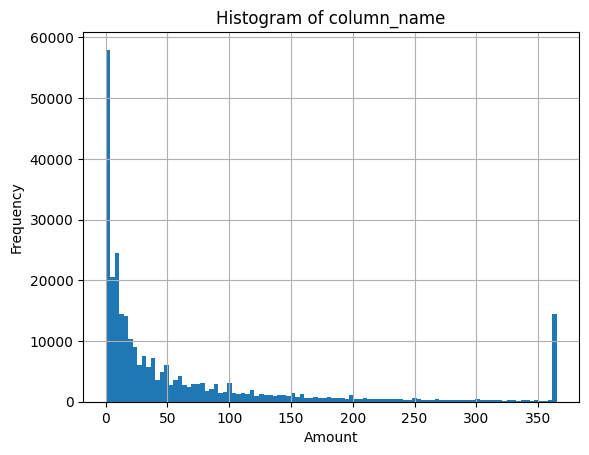

In [ ]:
import matplotlib.pyplot as plt

# There are some outliers that force a very ugly histogram. clip them.
percentile_95 = df[COL].quantile(0.95)

df['clipped'] = df[COL].apply(lambda x: min(x, percentile_95))

df['clipped'].hist(bins=100)
plt.xlabel(COL)
plt.ylabel('Frequency')
plt.title('Histogram of column_name')
plt.show()

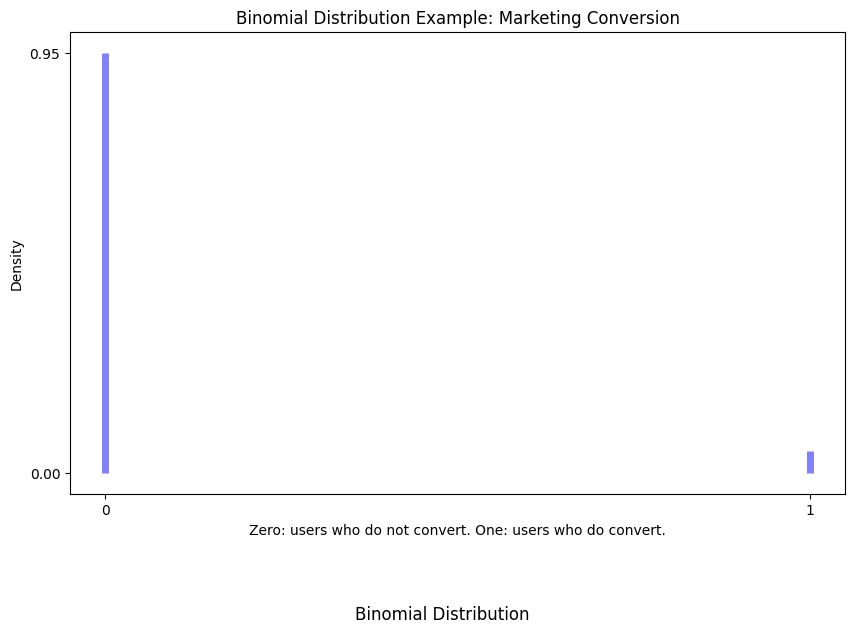

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom

# Parameters: n (number of trials), p (probability of success)
n, p = 1, 0.05

# Generate binomial distribution data
x = np.arange(0, n+1)
y = binom.pmf(x, n, p)

# Plotting
plt.figure(figsize=(10, 6))

# Use vertical lines to represent each bin
plt.vlines(x, 0, y, colors='b', lw=5, alpha=0.5)

# Labels and Title
plt.xlabel('Zero: users who do not convert. One: users who do convert.')
plt.ylabel('Density')
plt.title('Binomial Distribution Example: Marketing Conversion')
plt.figtext(0.5, -0.1, "Binomial Distribution ", wrap=True, horizontalalignment='center', fontsize=12)

# Set ticks
plt.xticks(np.arange(min(x), max(x)+1, 1))  # More vertical ticks
plt.yticks([0, max(y)])  # Only two horizontal ticks

plt.show()



In [135]:
import pandas as pd
from scipy.stats import norm, binom

# Initialize parameters
# Probability of a website visitor converting.
p = 0.01

# How confident we want to be in our numbers. Typically 90%, 95%, or 99%.
conf = 0.95

# Since we are trying to prevent the risk of estimating a conversion rate
# that is too high - we don't care if we estimated too low. So
# This is a one-sided lowertest (left tail) test.
percentile = 1.0 - conf

sample_sizes = [100, 200, 300, 500, 750, 1000]

# Initialize empty list to store rows
rows = []


# Loop through each sample size
for n_samples in sample_sizes:
    # The expected value for any visitor is 0.05: 5% chance they convert.
    mean = p

    # The standard deviation of a Bernoulli distribution.
    std_dev = (p * (1 - p)) ** 0.5

    std_err = std_dev / n_samples ** 0.5

    # Calculate the z-score for the cutoff between bottom 10% and top 90%.
    z_score = norm.ppf(percentile)

    # CLT one sided test
    clt = round((mean + z_score * std_err), 4)

    # EBT one sided test
    ebt = round(binom.ppf(percentile, n_samples, p) / n_samples, 4)

    # Append to rows
    rows.append([n_samples, clt, ebt,])

# Create DataFrame
df = pd.DataFrame(rows, columns=['n', 'CLT', 'EBT',])

# Start an empirical analysis. Generate a population.
population = [0] * int(10000 * (1-p)) + [1] * int(10000 * p)


# Randomly draw a sample and calculate mean conversion rate.
empirical = []
for n_samples in sample_sizes:
  sample_means = []
  # Repeat many times.
  for _ in range(10000):
    sample = np.random.choice(population, size=n_samples)
    sample_means.append(np.mean(sample))
  # From those many repeated draws, empirically calculate the cutoff
  # point between the bottom 1%, 5%, or 10%, and the top.
  empirical.append(np.percentile(sample_means, int(percentile * 100)))

df['EMP'] = empirical

# Convert decimals to percentages
# Convert the float values to percentages
for col in ['CLT', 'EBT', 'EMP']:
  df[col] = df[col].apply('{:.2%}'.format)

print(f"Lower bound with {conf} confidence (percent)")
print(df.to_string(index=False))

0.099498743710662
0.099498743710662
0.099498743710662
0.099498743710662
0.099498743710662
0.099498743710662
Lower bound with 0.95 confidence (percent)
   n    CLT   EBT   EMP
 100 -0.64% 0.00% 0.00%
 200 -0.16% 0.00% 0.00%
 300  0.06% 0.33% 0.33%
 500  0.27% 0.40% 0.40%
 750  0.40% 0.40% 0.40%
1000  0.48% 0.50% 0.50%


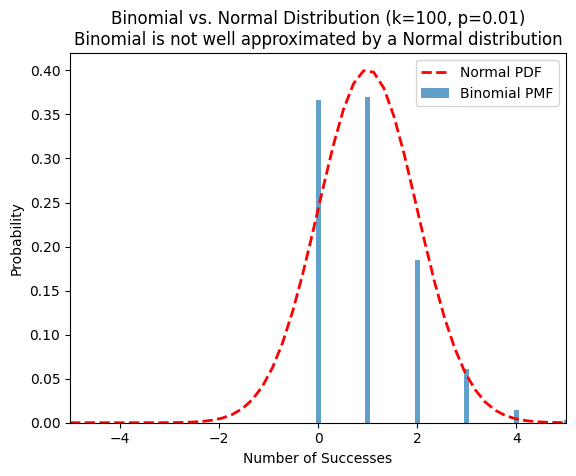

Mean of Binomial Distribution: 1.0
Variance of Binomial Distribution: 0.99


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

# Parameters for the binomial distribution
p = 0.01
k = 100

# Print area
x_vals=[-5, 5]

# Generate values for the binomial distribution
x = np.arange(0, k + 1)
binom_pmf = binom.pmf(x, k, p)

# Calculate mean and variance of the binomial distribution
binom_mean = k * p
binom_variance = k * p * (1 - p)

# Plot the binomial distribution
plt.bar(x, binom_pmf, label='Binomial PMF', alpha=0.7, width=0.1)

# Plot the normal distribution with the same mean and variance
x_normal = np.linspace(*x_vals)
normal_pdf = norm.pdf(x_normal, loc=binom_mean, scale=np.sqrt(binom_variance))
plt.plot(x_normal, normal_pdf, label='Normal PDF', linestyle='--', color='red', linewidth=2)

# Focus on just the center of the distribution
plt.xlim(*x_vals)

# Add labels and legend
plt.xlabel('Number of Successes')
plt.ylabel('Probability')
plt.legend()

# Title emphasizing the difference
plt.title(f'Binomial vs. Normal Distribution (k={k}, p={p})\nBinomial is not well approximated by a Normal distribution')

# Show the plot
plt.show()

# Print mean and variance
print(f"Mean of Binomial Distribution: {binom_mean}")
print(f"Variance of Binomial Distribution: {binom_variance}")
